In [1]:
# lib
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("..")

# set cwd one up
import os

os.chdir("..")
path = "data/hes/Hes1_example.csv"

In [2]:
from pyrocell.gp.gpflow import OscillatorDetector

osc = OscillatorDetector(path, "Time (h)", "Background", "Cell")

params = {"verbose": False, "plots": ["background", "detrend"]}
osc.run(**params)

(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=14.985654590425924>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=217.0221377220144>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=11.55108468522586>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=108.22712681743909>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=11.332923874111565>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=114.3025836583462>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=7.000006129512282>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=85.69146810948602>)
7.30222157549948
[0.15262064984160006, 0.07260499994054666, 0.181066611189315, 0.1154450536277496, 0.1439479229986904, 0.08800649862439577, 0.15438262617056325, 0.15583622141348946, 0.16605364570348283, 0.255769715055132, 0.07276131687989247, 0.0739

2024-11-24 19:34:06.309055: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-11-24 19:34:06.310562: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-11-24 19:34:09.162285: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-11-24 19:34:09.163386: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-11-24 19:34:14.240252: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular out

<Figure size 590.551x590.551 with 0 Axes>

In [3]:
print(osc.noise_list)

[0.15262064984160006, 0.07260499994054666, 0.181066611189315, 0.1154450536277496, 0.1439479229986904, 0.08800649862439577, 0.15438262617056325, 0.15583622141348946, 0.16605364570348283, 0.255769715055132, 0.07276131687989247, 0.0739812035055885]


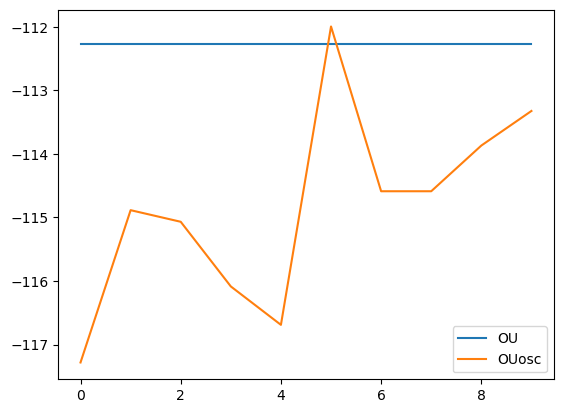

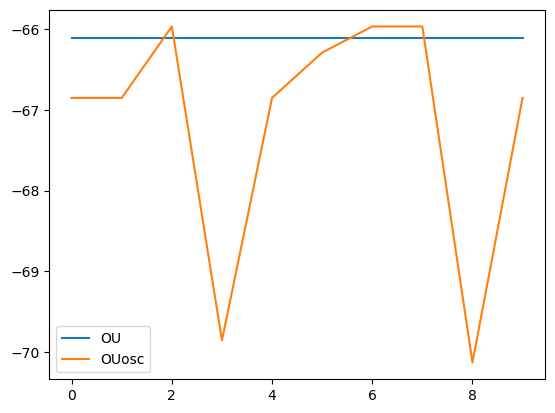

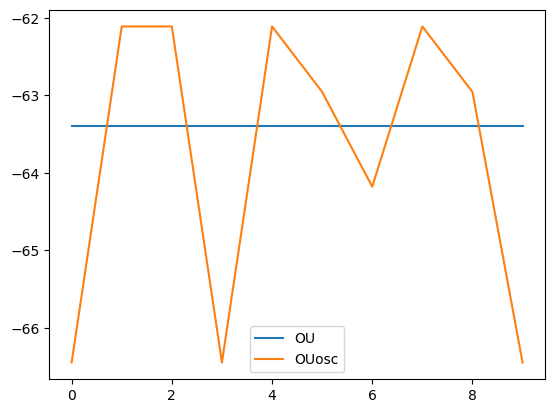

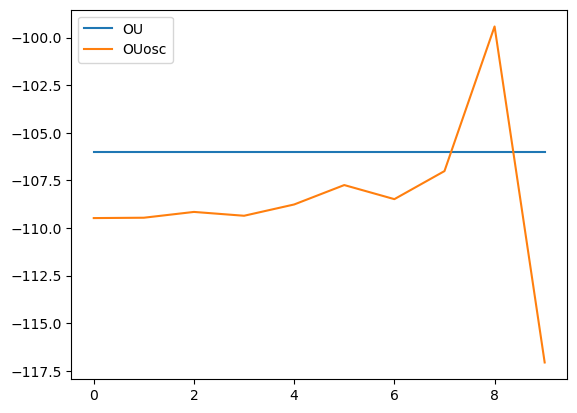

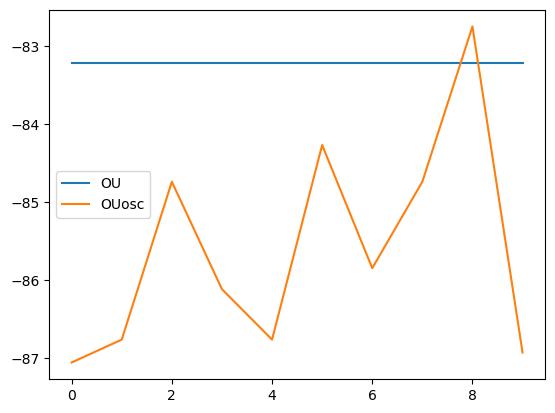

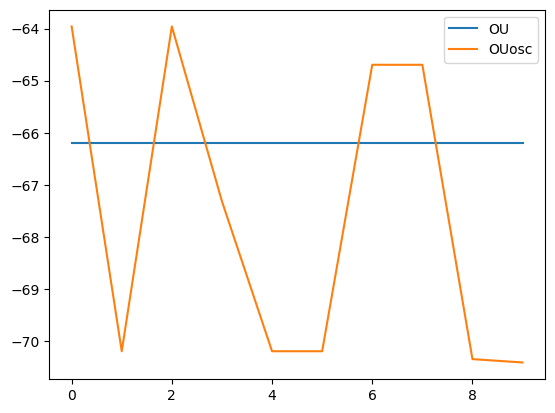

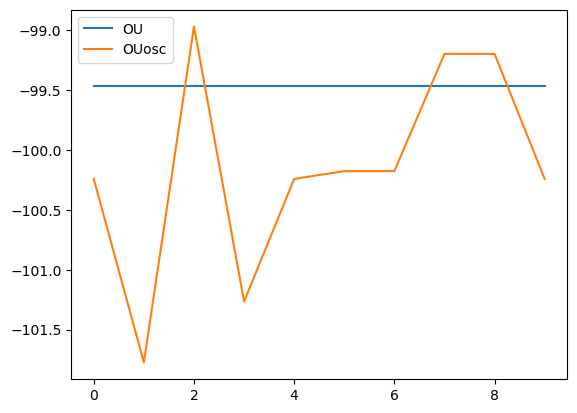

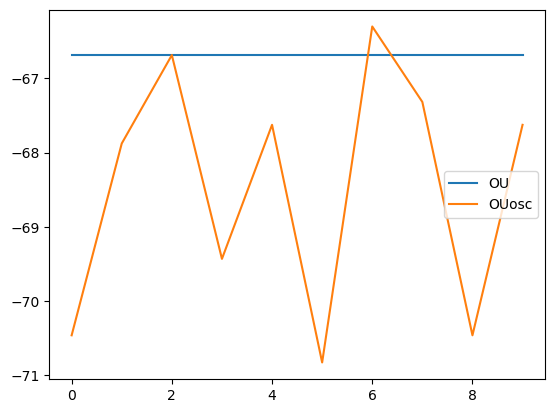

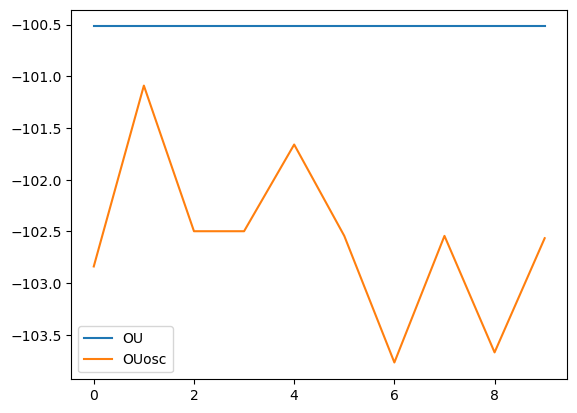

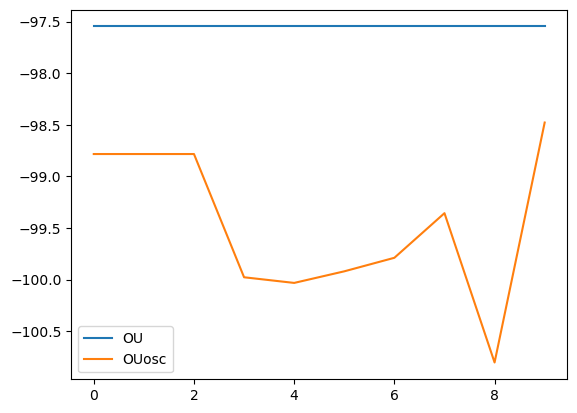

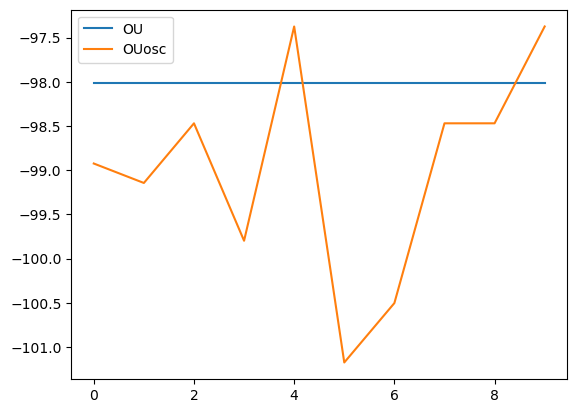

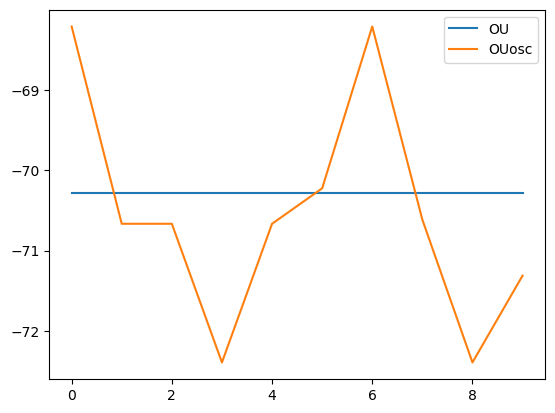

[233.6056854635023, 140.3211495903632, 134.73724323448607, 220.8149827351031, 175.09049666648397, 140.4094452929065, 207.56935197903138, 141.68184469564227, 209.74932275041678, 203.8086687933241, 204.6442088537899, 148.402647985184]
[237.58848435339684, 144.06702510612445, 136.13744439968048, 212.0079169973455, 178.4958644816477, 139.94219993396575, 210.8889398609141, 145.07830931254378, 215.2497290570724, 210.02715297105127, 207.66129343463507, 148.16302821040753]
[-3.982798889894525, -3.7458755157612416, -1.400201165194403, 8.807065737757597, -3.4053678151637143, 0.4672453589407439, -3.319587881882711, -3.396464616901511, -5.500406306655606, -6.218484177727163, -3.0170845808451645, 0.23961977477645746]


In [3]:
for ou, ouosc in zip(osc.ou_likelihoods, osc.ouosc_likelihoods):
    plt.plot(ou, label="OU")
    plt.plot(ouosc, label="OUosc")
    plt.legend()
    plt.show()


print(osc.ou_BICs)
print(osc.ouosc_BICs)
print(osc.BIC_diffs)

Number of cells counted as oscillatory (BIC method): 2/12


Text(0.5, 1.0, 'LLRs of experimental cells')

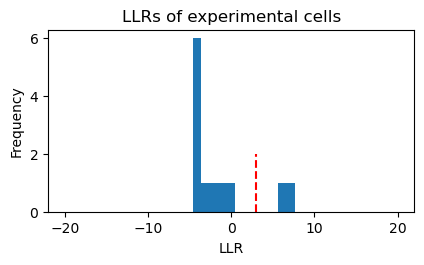

In [4]:
BICdiff_list = osc.BIC_diffs

fig = plt.figure(figsize=(12 / 2.54, 6 / 2.54))

cutoff = 3
print(
    "Number of cells counted as oscillatory (BIC method): {0}/{1}".format(
        sum(np.array(BICdiff_list) > cutoff), len(BICdiff_list)
    )
)

plt.hist(BICdiff_list, bins=np.linspace(-20, 20, 40))
plt.plot([cutoff, cutoff], [0, 2], "r--")
plt.xlabel("LLR")
plt.ylabel("Frequency")
plt.title("LLRs of experimental cells")

In [2]:
from pyrocell.gp.gpflow import *

ouosc_priors = {
    "lengthscale": uniform(0.1, 2.0),
    "variance": uniform(0.1, 2.0),
    "lengthscale_cos": uniform(0.1, 4.0),
    "train_likelihood": False,
    "train_osc_variance": False,
}

X, bckgd = load_data(path, "Time (h)", "Background")
print(len(X))
print(X[0].shape)
print(len(bckgd))
print(bckgd[0].shape)

4
(137, 1)
4
(137, 1)


In [3]:
background_noise(X, bckgd, 7.0, True)

Trained GP model:
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=14.985654590425924>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=217.0221377220144>, <Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=42.44515411655709>)
Trained GP model:
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=11.55108468522586>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=108.22712681743909>, <Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=73.23599899879841>)
Trained GP model:
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=11.332923874111565>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=114.3025836583462>, <Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=60.593439247140

(7.30222157549948,
  <pyrocell.gp.gpflow.backend.GaussianProcess at 0x28c100590>])